In [7]:
import pandas as pd
import numpy as np
import os
import collections
import csv
import random as rn
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from itertools import islice
from scipy.stats import beta as beta

# ------------------------------
# ----- PARAMETERS & SETUP -----
# ------------------------------

dataset_name = "seed_power_law_1"
authors_number = 20
months_number = 1
shuffling = True
shuffle_number = 100
add_special_ratings = True
readers_number = 2000
a_readers = .9
n_readers = 1000
papers_number = 2000
a_papers = .9
n_papers = 1000

# Seed folder path

dataset_folder_path = "../data/{}/".format(dataset_name)
dataset_shuffle_folder_path = "../data/{}/shuffle/".format(dataset_name)
dataset_shuffle_special_folder_path = "../data/{}/shuffle_special/".format(dataset_name)
dataset_entries_folder_path = "../data/{}/entries/".format(dataset_name)
dataset_plots_folder_path = "../data/{}/plots/".format(dataset_name)
reader_mappings_path = "{}reader_mappings.csv".format(dataset_entries_folder_path)
paper_mappings_path = "{}paper_mappings.csv".format(dataset_entries_folder_path)
rp_matrix_df_csv_path = "{}rp_matrix.csv".format(dataset_entries_folder_path)
ratings_file_path = "{}ratings.csv".format(dataset_entries_folder_path)
authors_file_path = "{}authors.csv".format(dataset_entries_folder_path)
info_file_path = "{}info.csv".format(dataset_entries_folder_path)
stats_file_path = "{}stats.csv".format(dataset_entries_folder_path)

os.makedirs(dataset_folder_path, exist_ok=True)
os.makedirs(dataset_entries_folder_path, exist_ok=True)
os.makedirs(dataset_plots_folder_path, exist_ok=True)

print("DATASET NAME: ", dataset_name)
print("DATASET FOLDER PATH: ", dataset_folder_path)
print("INFO FILE PATH: ", info_file_path)
print("RATINGS FILE PATH: ", ratings_file_path)
print("AUTHORS FILE PATH: ", authors_file_path)

# Functions

# Return first n items of the iterable as a list
def take(n, iterable):
    return list(islice(iterable, n))

def truncated_power_law(a, m):
    x = np.arange(1, m+1, dtype='float')
    pmf = 1/x**a
    pmf /= pmf.sum()
    return stats.rv_discrete(values=(range(1, m+1), pmf))

DATASET NAME:  seed_power_law_1
DATASET FOLDER PATH:  ../data/seed_power_law_1/
INFO FILE PATH:  ../data/seed_power_law_1/entries/info.csv
RATINGS FILE PATH:  ../data/seed_power_law_1/entries/ratings.csv
AUTHORS FILE PATH:  ../data/seed_power_law_1/entries/authors.csv


---------- INTER-READERS DISTRIBUTION GENERATION STARTED ----------
---------- PRINTING EXPECTED POWER LAW FOR READERS ----------
Expected Power Law Plot Saved at Path: ../data/seed_power_law_1/plots/expected-power-law-readers.pdf
Generated Readers: 2016
Distinct Readers Classes: 63 (i.e., m)
Total Amount of Ratings to Give:  62308
Minimum Number of Papers Required: 189
There Are 1 Readers Which Give 251 Ratings
There Are 2 Readers Which Give 150 Ratings
There Are 3 Readers Which Give 124 Ratings
There Are 5 Readers Which Give 104 Ratings
There Are 4 Readers Which Give 98 Ratings
There Are 7 Readers Which Give 89 Ratings
There Are 6 Readers Which Give 87 Ratings
There Are 9 Readers Which Give 81 Ratings
There Are 8 Readers Which Give 77 Ratings
There Are 11 Readers Which Give 75 Ratings
Etc.
---------- INTER-READERS DISTRIBUTION GENERATION COMPLETED ----------


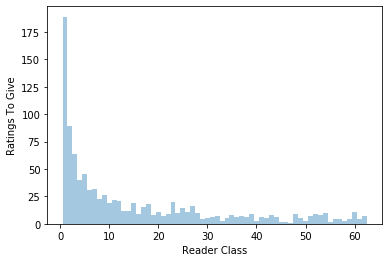

In [8]:
# ------------------------------
# ---- CORE IMPLEMENTATION -----
# ------------------------------

print("---------- INTER-READERS DISTRIBUTION GENERATION STARTED ----------")

res = 0
counter = 0
while res < readers_number:
  res = ((counter * (counter+1))/2)
  counter = counter + 1
counter = counter - 1
m = counter   
readers_number = int(res)
m_readers = m
a = a_readers
d = truncated_power_law(a=a, m=m)
n = n_readers
sample_readers = d.rvs(size=n)
ratings_number = 0
reader_rating_frequency = list(collections.Counter(sample_readers).most_common())[::-1]
for index, (readers_amount, rating_frequency) in enumerate(reader_rating_frequency):
    c = index
    if index > 0:
        while c > 0:
            if rating_frequency == reader_rating_frequency[index][1]:
                rating_frequency = rating_frequency + 1
                reader_rating_frequency[index] = (readers_amount, rating_frequency)
            c = c- 1
reader_rating_frequency = reader_rating_frequency[::-1]
for readers_amount,rating_frequency in reader_rating_frequency:
    ratings_number += readers_amount * rating_frequency
min_papers_number = collections.Counter(sample_readers).most_common()[0][1]

print("---------- PRINTING EXPECTED POWER LAW FOR READERS ----------")
ax = sns.distplot(sample_readers, bins=np.arange(m)+0.5, kde=False)
ax.set(xlabel="Reader Class", ylabel= "Ratings To Give")
fig = ax.get_figure()
path = "{}expected-power-law-readers.pdf".format(dataset_plots_folder_path)
fig.savefig(path, bbox_inches='tight')

print(f"Expected Power Law Plot Saved at Path: {path}")
print(f"Generated Readers: {readers_number}")
print(f"Distinct Readers Classes: {m} (i.e., m)")
print(f"Total Amount of Ratings to Give:  {ratings_number}")
print(f"Minimum Number of Papers Required: {min_papers_number}")
for readers_amount, rating_frequency in take(10, reader_rating_frequency):
    print(f"There Are {readers_amount} Readers Which Give {rating_frequency} Ratings")
print("Etc.")

print("---------- INTER-READERS DISTRIBUTION GENERATION COMPLETED ----------")

---------- INTER-PAPERS DISTRIBUTION GENERATION STARTED ----------
---------- PRINTING EXPECTED POWER LAW FOR PAPERS ----------
Expected Power Law Plot Saved at Path: ../data/seed_power_law_1/plots/expected-power-law-papers.pdf
Generated Papers: 2016
Distinct Papers Classes: 63 (i.e., m)
Minimum Number of Readers Required: 194
There Are 1 Papers Which Receive 256 Ratings
There Are 2 Papers Which Receive 152 Ratings
There Are 3 Papers Which Receive 123 Ratings
There Are 5 Papers Which Receive 100 Ratings
There Are 4 Papers Which Receive 95 Ratings
There Are 6 Papers Which Receive 85 Ratings
There Are 7 Papers Which Receive 82 Ratings
There Are 9 Papers Which Receive 79 Ratings
There Are 10 Papers Which Receive 78 Ratings
There Are 12 Papers Which Receive 73 Ratings
Etc.
---------- INTER-PAPERS DISTRIBUTION GENERATION COMPLETED ----------


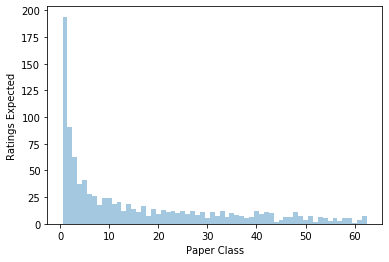

In [9]:
print("---------- INTER-PAPERS DISTRIBUTION GENERATION STARTED ----------")

res = 0
counter = 0
while res < papers_number:
  res = ((counter * (counter+1))/2)
  counter = counter + 1
counter = counter - 1
m = counter    
papers_number = int(res)
m_papers = m
a = a_papers
d = truncated_power_law(a=a, m=m)
n = n_papers
sample_papers = d.rvs(size=n)
paper_rating_frequency = list(collections.Counter(sample_papers).most_common())[::-1]
for index, (papers_amount, rating_frequency) in enumerate(paper_rating_frequency):
    c = index
    if index > 0:
        while c > 0:
            if rating_frequency == paper_rating_frequency[index][1]:
                rating_frequency = rating_frequency + 1
                paper_rating_frequency[index] = (papers_amount, rating_frequency)
            c = c- 1
paper_rating_frequency = paper_rating_frequency[::-1]
min_readers_number = collections.Counter(sample_papers).most_common()[0][1]

print("---------- PRINTING EXPECTED POWER LAW FOR PAPERS ----------")
ax = sns.distplot(sample_papers, bins=np.arange(m)+0.5, kde=False)
ax.set(xlabel="Paper Class", ylabel= "Ratings Expected")
fig = ax.get_figure()
path = "{}expected-power-law-papers.pdf".format(dataset_plots_folder_path)
fig.savefig(path, bbox_inches='tight')
print(f"Expected Power Law Plot Saved at Path: {path}")
print(f"Generated Papers: {papers_number}")
print(f"Distinct Papers Classes: {m_papers} (i.e., m)")
print(f"Minimum Number of Readers Required: {min_readers_number}")
for paper_amount, rating_frequency in take(10, paper_rating_frequency):
    print(f"There Are {paper_amount} Papers Which Receive {rating_frequency} Ratings")
print("Etc.")

print("---------- INTER-PAPERS DISTRIBUTION GENERATION COMPLETED ----------")

---------- READER-PAPER MATRIX GENERATION STARTED ----------
Total Papers: 2016
Building Paper Mappings...
Sampled Papers: 1 Remaining Papers: 2015
Sampled Papers: 2 Remaining Papers: 2013
Sampled Papers: 3 Remaining Papers: 2010
Sampled Papers: 5 Remaining Papers: 2005
Sampled Papers: 4 Remaining Papers: 2001
Sampled Papers: 6 Remaining Papers: 1995
Sampled Papers: 7 Remaining Papers: 1988
Sampled Papers: 9 Remaining Papers: 1979
Sampled Papers: 10 Remaining Papers: 1969
Sampled Papers: 12 Remaining Papers: 1957
Sampled Papers: 14 Remaining Papers: 1943
Sampled Papers: 11 Remaining Papers: 1932
Sampled Papers: 8 Remaining Papers: 1924
Sampled Papers: 17 Remaining Papers: 1907
Sampled Papers: 15 Remaining Papers: 1892
Sampled Papers: 19 Remaining Papers: 1873
Sampled Papers: 21 Remaining Papers: 1852
Sampled Papers: 25 Remaining Papers: 1827
Sampled Papers: 27 Remaining Papers: 1800
Sampled Papers: 40 Remaining Papers: 1760
Sampled Papers: 13 Remaining Papers: 1747
Sampled Papers: 23 R

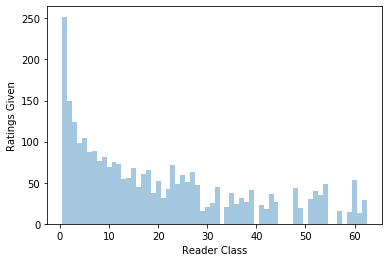

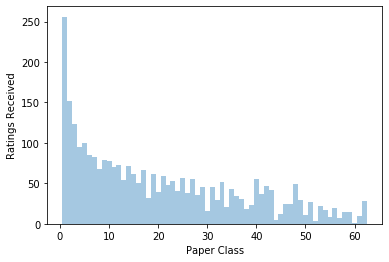

In [10]:
print("---------- READER-PAPER MATRIX GENERATION STARTED ----------")

# Setting up arrays for Readersourcing

readers = np.arange(readers_number)
authors = np.arange(authors_number)
papers = np.arange(papers_number)

rp_matrix = np.zeros_like(np.arange(readers_number * papers_number).reshape(readers_number, papers_number))

paper_mappings = pd.DataFrame(columns=["Paper", "Rating Frequency", "Ratings Received"])
paper_set = set(papers)
paper_sampled = set()
print(f"Total Papers: {len(paper_set)}")

print("Building Paper Mappings...")

for paper_amount, rating_frequency in paper_rating_frequency:
    sample = rn.sample(paper_set, paper_amount)
    for paper_id in sample:
        paper_sampled.add(paper_id)
        paper_set.remove(paper_id)
        paper_mappings = paper_mappings.append({"Paper": paper_id, "Rating Frequency": rating_frequency, "Ratings Received": 0}, ignore_index=True)
    print(f"Sampled Papers: {paper_amount} Remaining Papers: {len(paper_set)}")
    
print("Building Reader Mappings...")
    
reader_mappings = pd.DataFrame(columns=["Reader", "Rating Frequency", "Ratings Given"])
reader_set = set(readers)
print(f"Total Readers: {len(reader_set)}")
for reader_amount, rating_frequency in reader_rating_frequency:
    sample = rn.sample(reader_set, reader_amount)
    for reader_id in sample:
        reader_set.remove(reader_id)
        reader_mappings = reader_mappings.append({"Reader": reader_id, "Rating Frequency": rating_frequency, "Ratings Given": 0}, ignore_index=True)
    #print(f"Sampled Readers: {reader_amount} Remaining Readers: {len(reader_set)}")
       
print("Populating RP-Matrix...")
      
for reader_index, reader_row in reader_mappings.iterrows():
    
    reader_id = reader_row["Reader"]
    ratings_to_give = reader_row["Rating Frequency"]
    ratings_given = reader_row["Ratings Given"]
    #print("Handling {}/{} Readers; ID: {}, Ratings To Give: {}, Ratings Given {}"
    #      .format(reader_index, len(reader_mappings), reader_id, ratings_to_give, ratings_given))
    available_papers = paper_mappings[
        paper_mappings["Ratings Received"] < paper_mappings["Rating Frequency"]
    ].head(ratings_to_give)
        
    while ratings_given < ratings_to_give and len(available_papers) > 0:
        for paper_index, paper_row in available_papers.iterrows():
            paper_id = paper_row["Paper"]
            ratings_to_receive = paper_row["Rating Frequency"]
            ratings_received = paper_row["Ratings Received"]
            if ratings_received < ratings_to_receive:
                rp_matrix[reader_id, paper_id] = 1
                paper_mappings.loc[paper_index, "Ratings Received"] = ratings_received + 1
                reader_mappings.loc[reader_index, "Ratings Given"] = ratings_given + 1
                ratings_given = ratings_given + 1
            
reader_mappings.to_csv(reader_mappings_path)
paper_mappings.to_csv(paper_mappings_path)
rp_matrix_df = pd.DataFrame(dtype=int)
for paper_configuration in rp_matrix:
    rp_matrix_df = rp_matrix_df.append(pd.Series(paper_configuration),ignore_index=True)
rp_matrix_df = rp_matrix_df.astype(int)
rp_matrix_df.to_csv(rp_matrix_df_csv_path)

print("---------- PRINTING TRUE POWER LAW FOR READERS ----------")
temp = []
ratings_given = rp_matrix_df.sum(axis=1)
final_reader_rating_frequency = collections.Counter(ratings_given).most_common()
for index, (readers_amount, rating_frequency) in enumerate(final_reader_rating_frequency):
    temp.append([rating_frequency] * readers_amount)
temp = [item for sublist in temp for item in sublist]
ax = sns.distplot(temp, bins=np.arange(m_readers)+0.5, kde=False)
ax.set(xlabel="Reader Class", ylabel= "Ratings Given")
fig = ax.get_figure()
path_readers = "{}true-power-law-readers.pdf".format(dataset_plots_folder_path)
fig.savefig(path_readers, bbox_inches='tight')
plt.show()
plt.close()

# The true power law papers may be different from the expect one because
# it is not guaranteed that the full amount of papers will be sampled for
# each class; this means that the following instructions will "merge" together
# two or more classes if the same amount of papers have been sampled.
# (i.e, if there are 1 paper with 68 ratings and 1 paper with 5 ratings, the
# true power law will say something like "there are 1 paper which receives 73 ratings

print("---------- PRINTING TRUE POWER LAW FOR PAPERS ----------")
temp = []
ratings_received = rp_matrix_df.sum(axis=0)
final_paper_rating_frequency = collections.Counter(ratings_received).most_common()
for index, (papers_amount, rating_frequency) in enumerate(final_paper_rating_frequency):
    temp.append([rating_frequency] * papers_amount)
temp = [item for sublist in temp for item in sublist]
ax = sns.distplot(temp, bins=np.arange(m_papers)+0.5, kde=False)
ax.set(xlabel="Paper Class", ylabel= "Ratings Received")
fig = ax.get_figure()
path_papers = "{}true-power-law-papers.pdf".format(dataset_plots_folder_path)
fig.savefig(path_papers, bbox_inches='tight')
plt.show()
plt.close()

ratings_number = paper_mappings["Ratings Received"].sum()

print("Ratings Given By Readers (Expected): {}".format(reader_mappings["Ratings Given"].sum()))
print("Ratings Received By Papers (Actual): {}".format(paper_mappings["Ratings Received"].sum()))
print("Reader Mappings Saved at Path: {}".format(reader_mappings_path))
print("Paper Mappings Saved at Path: {}".format(paper_mappings_path))
print("Reader-Paper Matrix Saved at Path: {}".format(rp_matrix_df_csv_path))
print("True Power Law Plot (Readers) Saved at Path: {}".format(path_readers))
print("True Power Law Plot (Papers) Saved at Path: {}".format(path_papers))

print("---------- READER-PAPER MATRIX GENERATION COMPLETED ----------")

In [11]:
print("---------- INTRA-PAPER DISTRIBUTIONS GENERATION STARTED ----------")

generated_configurations = {"0":{},"1":{},"2":{},"3":{},"4":{}}

beta_distributions_frequencies = [(0, int(round((5*papers_number/100))))]
beta_distributions_frequencies.append((1, int(round(30*papers_number/100))))
beta_distributions_frequencies.append((2, int(round(20*papers_number/100))))
beta_distributions_frequencies.append((3, int(round(30*papers_number/100))))
beta_distributions_frequencies.append((4, int(round(15*papers_number/100))))
papers_amount = 0
for (index, papers_amount) in beta_distributions_frequencies:
    papers_amount += papers_amount
while papers_amount < papers_number:
    current_configuration = list(rn.sample(beta_distributions_frequencies, 1)[0])
    current_configuration[1] = current_configuration[1] + 1
    beta_distributions_frequencies[current_configuration[0]] = tuple(current_configuration)
    papers_amount = 0
    for (index, z) in beta_distributions_frequencies:
        papers_amount += z

papers_set = set(papers)
paper_distributions = [None] * papers_number

generated_papers_distributions = 0
for (index, papers_amount) in beta_distributions_frequencies:
    if papers_amount > len(papers_set):
        papers_amount = len(papers_set)
    current_paper_set = rn.sample(papers_set, papers_amount)
    generated_configurations["{}".format(index)]["papers_ids"] = current_paper_set
    generated_configurations["{}".format(index)]["papers_amount"] = papers_amount
    for paper in current_paper_set:
        a = 0
        b = 0
        if index==0:
            # CASE 1: a == b == 1, 5% of papers
            a = 1
            b = 1
        if index==1:
            # CASE 2: a == b > 1, 30% of papers
            a = rn.randint(2, 10)
            b = a
        if index == 2:
            # CASE 3: 0 < (a ^ b) < 1, 30% of papers
            a = rn.uniform(0.3, 1)
            b = rn.uniform(0.001, 1)
        if index == 3:
            # CASE 4: (a V b) == 1, (a > b V b > a), 20% of papers
            a = 1
            b = rn.randint(1, 10)
            if rn.randint(0,1) > 0.5:
                a, b = b, a
        if index == 4:
            # CASE 5: (a ^ b) > 1, (a > b V b > a), 15% of papers
            a = rn.randint(2, 10)
            b = rn.randint(2 + a, 10 + a)
            if rn.randint(0,1) > 0.5:
                a, b = b, a
        percentage = 100*generated_papers_distributions/papers_number
        if percentage % 10 == 0:
            print("{}/{} ({}/100%)".format(int(generated_papers_distributions), papers_number, int(percentage)))
        paper_distributions[paper] = [a, b]
        generated_papers_distributions = generated_papers_distributions + 1
        papers_set.remove(paper)
print("{}/{} (100/100%)".format(papers_number, papers_number))

print("---------- INTRA-PAPER DISTRIBUTIONS GENERATION COMPLETED ----------")

---------- INTRA-PAPER DISTRIBUTIONS GENERATION STARTED ----------
0/2016 (0/100%)
1008/2016 (50/100%)
2016/2016 (100/100%)
---------- INTRA-PAPER DISTRIBUTIONS GENERATION COMPLETED ----------


In [12]:
print("---------- RATINGS GENERATION STARTED ----------")

generated_ratings = 0
with open(ratings_file_path, mode='w', newline='') as ratings_file:
    ratings_writer = csv.writer(ratings_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    ratings_writer.writerow(['Timestamp', 'Reader', 'Paper', 'Score','Reader-Label'])
    for reader, papers_configuration in rp_matrix_df.iterrows():
        for paper in papers:
            if papers_configuration[paper] == 1:
                paper_distribution = beta(paper_distributions[paper][0],paper_distributions[paper][1])
                percentage = 100*generated_ratings/ratings_number
                if percentage % 10 == 0:
                    print("{}/{} ({}/100%)".format(int(generated_ratings), ratings_number, int(percentage)))
                generated_rating = round(paper_distribution.rvs(1)[0], 2)
                if generated_rating == 0:
                    generated_rating = 0.01
                ratings_writer.writerow([
                    generated_ratings, 
                    reader, 
                    paper, 
                    generated_rating,
                    "R#{}".format(reader)
                ])
                generated_ratings+=1
    print("{}/{} (100/100%)".format(ratings_number, ratings_number))
    
ratings_file.close()

paper_ratings = pd.read_csv(ratings_file_path)
paper_ratings = paper_ratings.sample(frac=1)
paper_ratings["Timestamp"] = range(len(paper_ratings))
paper_ratings.reset_index(drop=True, inplace=True)

paper_ratings.to_csv(ratings_file_path, index=False, header=True, sep=",")

print("Ratings Timeserie Saved at Path: {}".format(ratings_file_path))

print("---------- RATINGS GENERATION ENDED ----------")

---------- RATINGS GENERATION STARTED ----------
0/59502 (0/100%)
29751/59502 (50/100%)
59502/59502 (100/100%)
Ratings Timeserie Saved at Path: ../data/seed_power_law_1/entries/ratings.csv
---------- RATINGS GENERATION ENDED ----------


In [13]:
# Authors file generation

print("---------- AUTHORS GENERATION STARTED ----------")

with open(authors_file_path, mode='w', newline='') as authors_file:
    authors_writer = csv.writer(authors_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    authors_writer.writerow(["Author", "Paper"])
    for index, author in enumerate(authors):
        percentage = 100*index/authors_number
        if percentage % 10 == 0:
            print("{}/{} ({}/100%)".format(int(index), authors_number, int(percentage)))
        # An author writes a number of paper between 1 and paper_fraction
        author_papers_number = rn.randint(1, (papers_number-1))
        papers_written = np.random.choice(papers, author_papers_number).tolist()
        papers_written = set(papers_written)
        if len(papers_written) > 1:
            papers_written = map(str, list(papers_written))
            papers_written = ";".join(papers_written)
        else:
            papers_written = list(papers_written)[0]
        authors_writer.writerow([author, papers_written])
    print("{}/{} (100/100%)".format(authors_number, authors_number))
authors_file.close()

print("Authors File Saved at Path: {}".format(authors_file_path))
        
print("---------- AUTHORS GENERATION ENDED ----------")

# Info file generation

print("---------- INFO GENERATION STARTED ----------")

info_dataframe = pd.DataFrame(columns=["Dataset", "Paper", "Reader", "Rating", "Author"])
info_dataframe = info_dataframe.append(
    {
        "Dataset": dataset_name, 
        "Paper": papers_number, 
        "Reader": readers_number, 
        "Rating": ratings_number, 
        "Author": authors_number
    }, ignore_index=True)
info_dataframe.to_csv(info_file_path, index=False)

print("Info File Saved at Path: {}".format(info_file_path))

print("---------- INFO GENERATION ENDED ----------")

---------- AUTHORS GENERATION STARTED ----------
0/20 (0/100%)
2/20 (10/100%)
4/20 (20/100%)
6/20 (30/100%)
8/20 (40/100%)
10/20 (50/100%)
12/20 (60/100%)
14/20 (70/100%)
16/20 (80/100%)
18/20 (90/100%)
20/20 (100/100%)
Authors File Saved at Path: ../data/seed_power_law_1/entries/authors.csv
---------- AUTHORS GENERATION ENDED ----------
---------- INFO GENERATION STARTED ----------
Info File Saved at Path: ../data/seed_power_law_1/entries/info.csv
---------- INFO GENERATION ENDED ----------


In [14]:
# Stats file generation

print("---------- STATS GENERATION STARTED ----------")

temp_ratings_dataframe = pd.read_csv(ratings_file_path)
temp_ratings_dataframe = temp_ratings_dataframe.loc[:, temp_ratings_dataframe.columns != "Reader-Label"]
temp_ratings_dataframe[temp_ratings_dataframe.columns] = temp_ratings_dataframe[temp_ratings_dataframe.columns].apply(pd.to_numeric)

stats_dataframe = temp_ratings_dataframe.copy()
stats_dataframe[stats_dataframe > 0.0000001] = 1

print("---------- COMPUTING STATS FOR PAPERS ----------")

sums_paper = stats_dataframe.copy().sum(axis=0)
sums_paper_dataframe = pd.DataFrame(sums_paper)

max_ratings_paper = sums_paper_dataframe.max()
min_ratings_paper = sums_paper_dataframe.min()
mean_ratings_paper = sums_paper_dataframe.mean()

temp_ratings_dataframe = temp_ratings_dataframe.T
paper_counter = 0
for index, row in temp_ratings_dataframe.iterrows():
    if len(np.unique(row)) == 1:
        paper_counter+=1
        
print("---------- COMPUTING STATS FOR READERS ----------")

sums_reader = stats_dataframe.copy().sum(axis=1)
counter=collections.Counter(sums_reader)
sums_reader_dataframe = pd.DataFrame(sums_reader)

max_ratings_reader = sums_reader_dataframe.max()
min_ratings_reader = sums_reader_dataframe.min()
mean_ratings_reader = sums_reader_dataframe.mean()

temp_ratings_dataframe = temp_ratings_dataframe
reader_counter = 0
for index, row in temp_ratings_dataframe.iterrows():
    if len(np.unique(row)) == 1:
        reader_counter+=1
        
# Writing stats to file

stats_dataframe = pd.DataFrame(columns=[
    "Dataset",
    "Max Number Rating Paper", 
    "Min Number Rating Paper", 
    "Mean Number Rating Paper",
    "Number Papers Unique Ratings",
    "Max Number Rating Reader", 
    "Min Number Rating Reader", 
    "Mean Number Rating Reader"
    "Number Readers Unique Rating"
])
stats_dataframe = stats_dataframe.append(
    {
        "Dataset": dataset_name, 
        "Max Number Rating Paper": int(max_ratings_paper.values[0]), 
        "Min Number Rating Paper": int(min_ratings_paper.values[0]), 
        "Number Papers Unique Ratings": paper_counter, 
        "Mean Number Rating Paper": int(mean_ratings_paper.values[0]), 
        "Max Number Rating Reader": int(max_ratings_reader.values[0]), 
        "Min Number Rating Reader": int(min_ratings_reader.values[0]), 
        "Mean Number Rating Reader": int(mean_ratings_reader.values[0]), 
        "Number Readers Unique Rating": reader_counter, 
    }, ignore_index=True)
stats_dataframe.to_csv(stats_file_path, index=False)

print("Stats File Saved at Path: {}".format(stats_file_path))

print("---------- STATS GENERATION COMPLETED ----------")

---------- STATS GENERATION STARTED ----------
---------- COMPUTING STATS FOR PAPERS ----------
---------- COMPUTING STATS FOR READERS ----------
Stats File Saved at Path: ../data/seed_power_law_1/entries/stats.csv
---------- STATS GENERATION COMPLETED ----------


In [15]:
# Data generation for experiments

# ------------------------------
# -- EXP 1-A: DATA GENERATION --
# ------------------------------

print("---------- SPECIAL RATINGS STARTED ----------")

if add_special_ratings:
    
    from shutil import copyfile

    ratings_file_path_special = "{}ratings_special.csv".format(dataset_entries_folder_path)
    info_file_path_special = "{}info_special.csv".format(dataset_entries_folder_path)

    copyfile(ratings_file_path, ratings_file_path_special)
    copyfile(info_file_path, info_file_path_special)
    
    gaussian_beta_distributions = generated_configurations["2"]
    papers_identifiers = gaussian_beta_distributions["papers_ids"]
    
    for paper in papers_identifiers:
        mean = (paper_distributions[paper][0]/(paper_distributions[paper][0] + paper_distributions[paper][1]))
        SR1_rating_id = generated_ratings
        SR1_reader = readers_number
        SR1_paper = paper
        SR1_rating_score = round(mean,2)
        SR1_reader_label = "SR#1"
        SR2_rating_id = generated_ratings+1
        SR2_reader = readers_number+1
        SR2_paper = paper
        SR2_reader_label = "SR#2"
        SR3_rating_id = generated_ratings+2
        SR3_reader = readers_number+2
        SR3_paper = paper
        SR3_reader_label = "SR#3"
        if mean <= 0.5:
            SR2_rating_score = 0.01
            SR3_rating_score = round(((1-mean)/2),2)
        else:
            SR2_rating_score = 1.0
            SR3_rating_score = round((mean/2),2)
        with open(ratings_file_path_special, mode='a', newline='') as ratings_file:
            ratings_writer = csv.writer(ratings_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
            ratings_writer.writerow([SR1_rating_id, SR1_reader, SR1_paper, SR1_rating_score, SR1_reader_label])
            ratings_writer.writerow([SR2_rating_id, SR2_reader, SR2_paper, SR2_rating_score, SR2_reader_label])
            ratings_writer.writerow([SR3_rating_id, SR3_reader, SR3_paper, SR3_rating_score, SR3_reader_label])
        ratings_file.close()
        generated_ratings = generated_ratings + 3
    ratings_number = generated_ratings
    readers_number = readers_number + 3
    
    print("Ratings file with special ratings saved at path: {}".format(ratings_file_path_special))
        
    # Updating info file
    
    info_dataframe = pd.DataFrame(columns=["Dataset", "Paper", "Reader", "Rating", "Author"])
    info_dataframe = info_dataframe.append(
        {
            "Dataset": dataset_name, 
            "Paper": papers_number, 
            "Reader": readers_number, 
            "Rating": ratings_number, 
            "Author": authors_number
        }, ignore_index=True)
    info_dataframe.to_csv(info_file_path_special, index=False)
    
    print("Updated info file saved at path: {}".format(info_file_path_special))
    
    ratings_file_path = "{}ratings_special.csv".format(dataset_entries_folder_path)
    info_file_path = "{}info_special.csv".format(dataset_entries_folder_path)
    chosen_shuffle_path = "{}".format(dataset_shuffle_special_folder_path)
    
    if shuffling:
        paper_ratings = pd.read_csv(ratings_file_path)
        os.makedirs(chosen_shuffle_path, exist_ok=True)
        for s in range(shuffle_number):
            c = 0
            if s % 10 == 0:
                print("{}/{} ({}/100%)".format(s, shuffle_number, s))
            current_shuffle_file_path = "{}shuffle_{}.csv".format(chosen_shuffle_path, s)
            shuffled_papers_ratings = paper_ratings.sample(frac=1)
            for i, row in shuffled_papers_ratings.iterrows():
                shuffled_papers_ratings.at[i,'Timestamp'] = c
                c  = c + 1
            shuffled_papers_ratings.to_csv(current_shuffle_file_path, index=False, header=True, sep=",")
        
    print("{}/{} (100/100%)".format(shuffle_number, shuffle_number))

print("---------- SPECIAL RATINGS COMPLETED  ----------")

---------- SPECIAL RATINGS STARTED ----------
Ratings file with special ratings saved at path: ../data/seed_power_law_1/entries/ratings_special.csv
Updated info file saved at path: ../data/seed_power_law_1/entries/info_special.csv
0/100 (0/100%)
10/100 (10/100%)
20/100 (20/100%)
30/100 (30/100%)
40/100 (40/100%)
50/100 (50/100%)
60/100 (60/100%)
70/100 (70/100%)
80/100 (80/100%)
90/100 (90/100%)
100/100 (100/100%)
---------- SPECIAL RATINGS COMPLETED  ----------


In [16]:
# ------------------------------
# -- EXP 1-B: DATA GENERATION --
# ------------------------------

print("---------- RATINGS SHUFFLING STARTED ----------")
    
if shuffling:
    
    ratings_file_path = "{}ratings.csv".format(dataset_entries_folder_path)
    info_file_path = "{}info.csv".format(dataset_entries_folder_path)
    chosen_shuffle_path = "{}/".format(dataset_shuffle_folder_path)
    
    paper_ratings = pd.read_csv(ratings_file_path)
    os.makedirs(chosen_shuffle_path, exist_ok=True)
    for s in range(shuffle_number):
        c = 0
        if s % 10 == 0:
            print("{}/{} ({}/100%)".format(s, shuffle_number, s))
        current_shuffle_file_path = "{}shuffle_{}.csv".format(chosen_shuffle_path, s)
        shuffled_papers_ratings = paper_ratings.sample(frac=1)
        for i, row in shuffled_papers_ratings.iterrows():
            shuffled_papers_ratings.at[i,'Timestamp'] = c
            c  = c + 1
        shuffled_papers_ratings.to_csv(current_shuffle_file_path, index=False, header=True, sep=",")
        
    print("{}/{} (100/100%)".format(shuffle_number, shuffle_number))
    
print("---------- RATINGS SHUFFLING COMPLETED ----------")


---------- RATINGS SHUFFLING STARTED ----------
0/100 (0/100%)
10/100 (10/100%)
20/100 (20/100%)
30/100 (30/100%)
40/100 (40/100%)
50/100 (50/100%)
60/100 (60/100%)
70/100 (70/100%)
80/100 (80/100%)
90/100 (90/100%)
100/100 (100/100%)
---------- RATINGS SHUFFLING COMPLETED ----------
